In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Myeloid/scvi_latent20/"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
# load general annotations to isolate Myeloid cells only
general_annot = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/annotation_global/Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_clustering.h5ad"
)

In [5]:
general_annot.shape

(107428, 2000)

In [6]:
general_annot.obs.Annotation_scVI.value_counts()

T-NK-ILC       82184
Myeloid        19398
B               2116
Plasma          1610
Stromal         1009
Endothelial      559
Hepatocyte       467
Mast              85
Name: Annotation_scVI, dtype: int64

In [7]:
# these are the cells we need to extract from the raw data to get raw counts
idx2extract = general_annot[general_annot.obs.Annotation_scVI == "Myeloid"].obs.index

In [8]:
len(idx2extract)

19398

In [9]:
# load raw counts from merged object
adata_raw = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/data_integration/Multiome_Che_Wu_CRC_LM_raw.h5ad"
)

In [10]:
# select from the raw data only the barcodes of interest, select raw counts from cell population of interest
adata = adata_raw[adata_raw.obs.index.isin(idx2extract)].copy()
adata.shape

(19398, 37102)

In [11]:
# add global annotations to raw data
adata.obs = adata.obs.merge(
    right=general_annot.obs[["Annotation_scVI"]],
    how="left",
    right_index=True,
    left_index=True,
)

In [12]:
adata.obs.cell_source.value_counts()

Wu-Cells      9215
Che-Cells     8272
BCI-Nuclei    1911
Name: cell_source, dtype: int64

In [12]:
# check that it is raw data
np.max(adata.X)

16150.0

In [13]:
adata.obs.Patient.value_counts()

Wu2021_P14    3453
COL15         3101
COL07         1633
Wu2021_P13    1596
COL17         1358
COL18         1184
Wu2021_P18    1034
COL16          816
Wu2021_P20     488
Wu2021_P15     468
CRC08          446
Wu2021_P19     386
Wu2021_P17     384
Wu2021_P10     320
Wu2021_P16     257
CRC12          246
Wu2021_P3      242
CRC15          222
CRC10          207
Wu2021_P2      191
COL12          180
Wu2021_P12     171
CRC03          161
CRC04          147
CRC09          107
CRC11           91
Wu2021_P6       78
Wu2021_P8       76
CRC06           73
CRC14           55
CRC13           53
CRC02           51
Wu2021_P1       41
CRC05           22
CRC07           19
CRC01           11
Wu2021_P11       8
Wu2021_P4        7
Wu2021_P7        7
Wu2021_P9        5
Wu2021_P5        3
Name: Patient, dtype: int64

### look at covariates

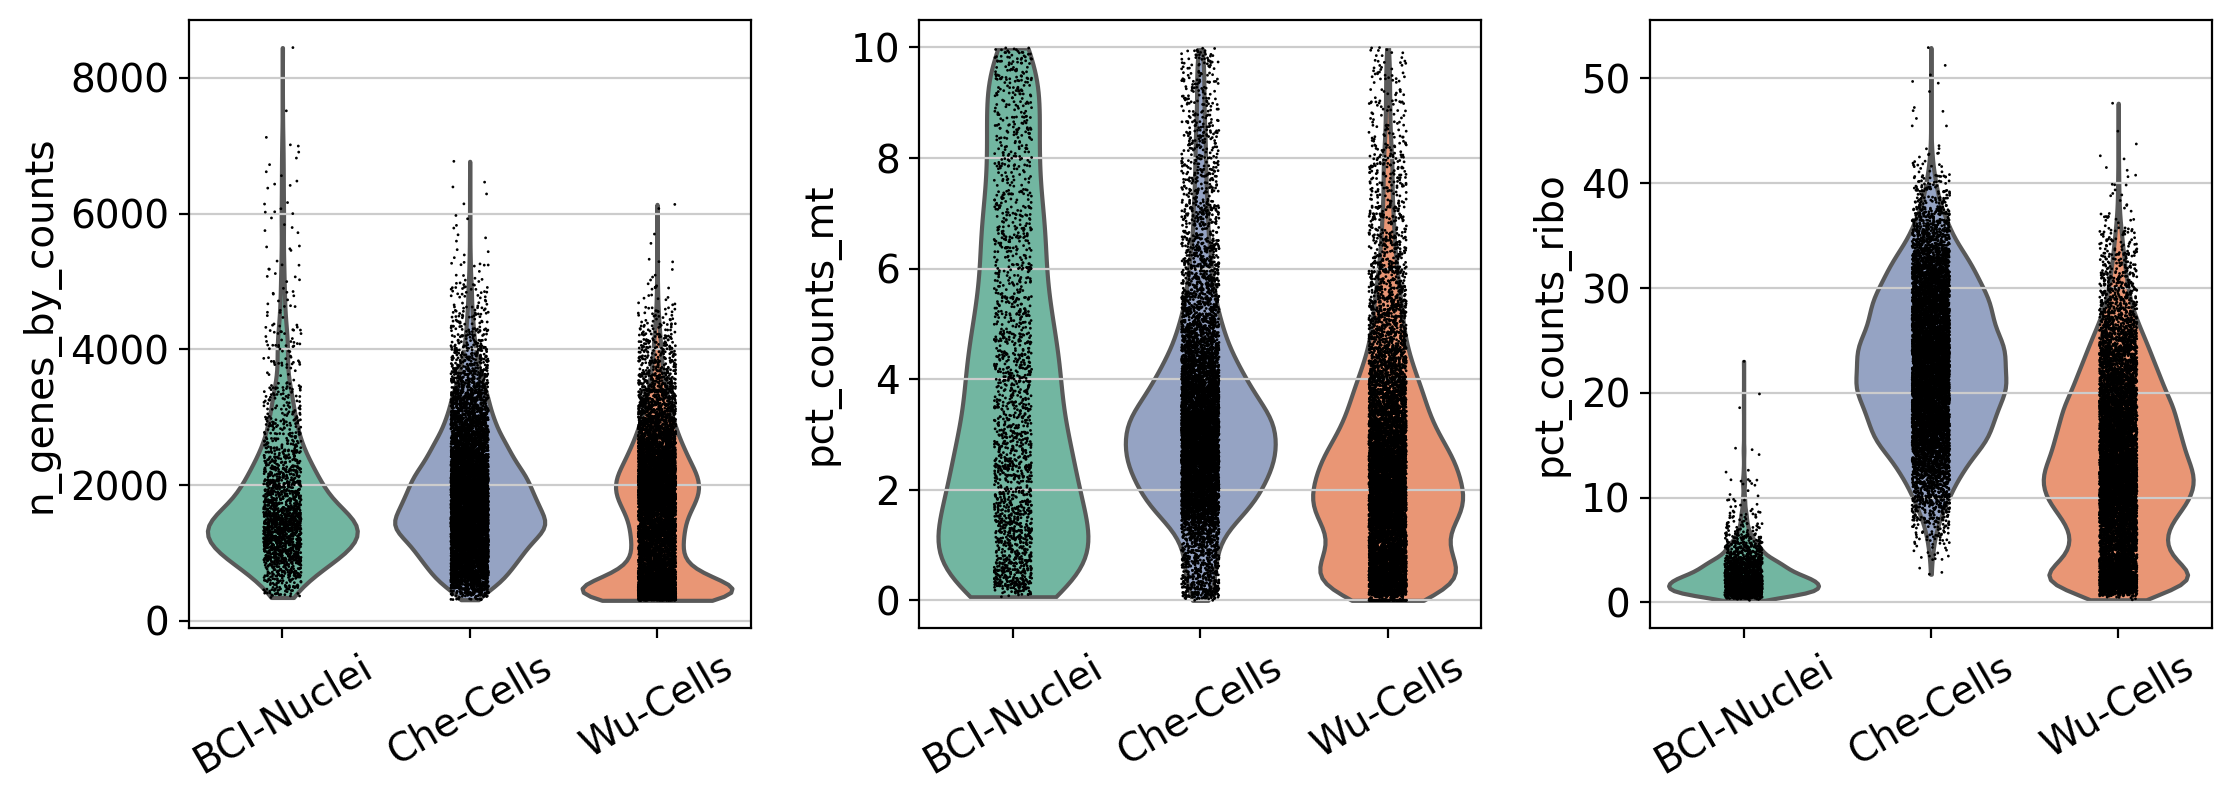

In [14]:
# violin plot of some distributions
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    groupby="cell_source",
    jitter=0.1,
    multi_panel=True,
    rotation=30,
    show=True,
    # save="QC_covariates.pdf",
)

### Normalise + log transform + HVG

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.


In [15]:
# keep raw
adata.layers["raw"] = adata.X.copy()  # preserve counts

# normalize + log1p
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
adata.layers["normalised"] = adata.X.copy()
sc.pp.log1p(adata)

adata.layers["log1p"] = adata.X.copy()

The count data has been normalized and log-transforme d with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

In [16]:
adata.raw = adata  # keep normalised log1p

### Compute cell cycle scores 

In [17]:
def cell_cycle_scoring(adata, cc_genes_file, subtract=False, use_raw=True):
    """
    Computes cell cycle G2M and S phase scores using provided list
    :param adata: need log1p normalised data
    :param cc_genes_file: list of cell cycling genes (often list provided Macosko et al. 2015)
    :param subtract: compute the difference between the S and G2M scores
    :param use_raw: adata.raw where log1p norm is stored, by default True
    :return:
    """
    cc_genes = pd.read_csv(cc_genes_file)

    cc_genes = list(cc_genes["Cell_cycle_genes"])

    # select only cell cycle genes involved in phase S
    cc_genes_s = cc_genes[:43]
    # select only cell cycle genes involved in phase G2/M
    cc_genes_g2m = cc_genes[43:]

    # select cc_genes that are in our gene repertoire
    # isin is an element-wise function version of the python keyword in. isin(a, b) is roughly equivalent to
    # np.array([item in b for item in a]) if a and b are 1-D sequences.
    # cc_genes_s_var = adata.raw.to_adata().var_names[np.isin(adata.raw.to_adata().var_names, cc_genes_s)]
    # cc_genes_g2m_var = adata.raw.to_adata().var_names[np.in1d(adata.raw.to_adata(), cc_genes_g2m)]

    cc_genes_s_var = [
        ele for ele in cc_genes_s if ele in adata.raw.to_adata().var_names
    ]
    cc_genes_g2m_var = [
        ele for ele in cc_genes_g2m if ele in adata.raw.to_adata().var_names
    ]

    # to ensure reproducibility from issue https://github.com/theislab/scanpy/issues/313
    # adata.X = adata.X.astype('<f8')  # Make float64 to ensure stability

    sc.tl.score_genes_cell_cycle(
        adata,
        s_genes=cc_genes_s_var,
        g2m_genes=cc_genes_g2m_var,
        random_state=7,
        use_raw=use_raw,
    )

    if subtract:  # https://satijalab.org/seurat/archive/v3.0/cell_cycle_vignette.html
        # regressing out the difference between the G2M and S phase scores.
        # This means that signals separating non-cycling cells and cycling cells will be maintained,
        # but differences in cell cycle phase amongst proliferating cells (which are often uninteresting),
        # subtracting scores individually removes all signal associated with cell cycle but not always good.
        # Sometimes useful to try differences
        # particularly in differentiating processes (like murine hematopoiesis), where stem cells are quiescent
        # and differentiated cells are proliferating. Regressing out all cell cycle effects can blur the distinction
        # between stem and progenitor cells as well
        adata.obs["cell_cycle_diff"] = adata.obs["S_score"] - adata.obs["G2M_score"]
        # https://github.com/theislab/scanpy/issues/526

    # adata.X = adata.X.astype('<f4')  # Return to float32 for consistency

    return adata

In [18]:
cell_cycle_scoring(
    adata,
    cc_genes_file="/data/BCI-CRC/nasrine/data/Tirosh2016_coreCellCycle.csv",
    subtract=True,
    use_raw=True,
)  # use log1p norm data

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


AnnData object with n_obs × n_vars = 19398 × 37102
    obs: 'Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy', 'doublet_score', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'cell_source', 'Annotation_scVI', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff'
    var: 'n_cells'
    uns: 'Therapy_colors', 'Tissue_colors', 'cell_source_colors', 'log1p'
    layers: 'raw', 'normalised', 'log1p'

### HVG 
We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

**Expects logarithmized data, except when `flavor='seurat_v3'` in which
count data is expected.**

In [19]:
sc.pp.highly_variable_genes(
    adata,
    subset=True,  # subset for integration (but full lognorm data in .raw)
    layer="raw",
    flavor="seurat_v3",
    n_top_genes=2000,
    span=0.3,
    min_disp=0.5,
    min_mean=0.0125,
    max_mean=3,
    batch_key="cell_source",
)

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [20]:
adata.X.shape

(19398, 2000)

In [21]:
adata.raw.to_adata().X.shape

(19398, 37102)

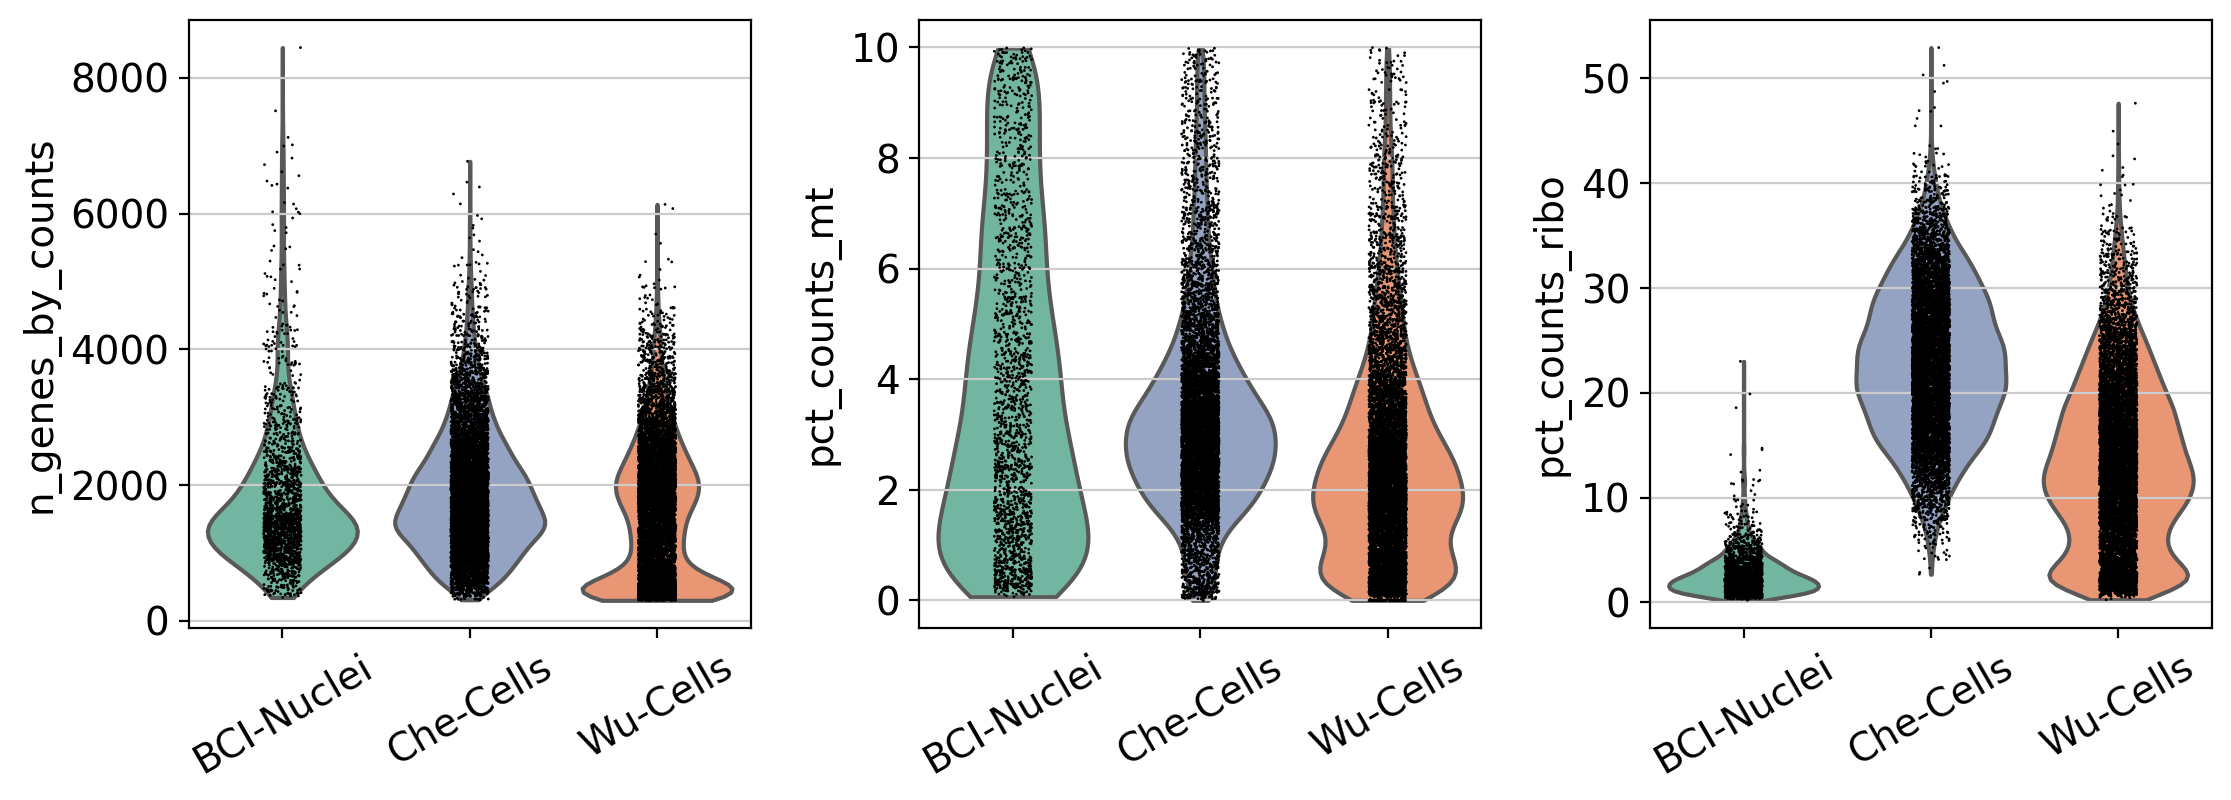

In [22]:
# violin plot of some distributions
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    groupby="cell_source",
    jitter=0.1,
    multi_panel=True,
    rotation=30,
    show=True,
    save="QC_covariates.pdf",
)

### scVI
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized).

Now it’s time to run setup_anndata(), which alerts scvi-tools to the locations of various matrices inside the anndata. It’s important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a “cell_source” categorical covariate, and within each “cell_source”, multiple “patients”. There are also two continuous covariates we’d like to correct for: “percent_mito” and “percent_ribo”. These covariates can be registered using the categorical_covariate_keys argument. If you only have one categorical covariate, you can also use the batch_key argument instead.



In [23]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="raw",
    categorical_covariate_keys=["cell_source", "Patient"],
    continuous_covariate_keys=[
        "pct_counts_mt",
        "pct_counts_ribo",
    ],  # add cell cycle here if you want to correct for this
)

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[raw] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


#### Creating and training a model

In [24]:
model = scvi.model.SCVI(adata, n_latent=20)  # n_latent=10
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 20, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [25]:
model.train()

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/400:   0%|          | 1/400 [00:04<30:59,  4.66s/it, loss=727, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/400:   0%|          | 2/400 [00:08<29:13,  4.41s/it, loss=662, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 4/400:   1%|          | 3/400 [00:12<28:10,  4.26s/it, loss=665, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/400:   1%|          | 4/400 [00:17<27:53,  4.23s/it, loss=652, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 6/400:   1%|▏         | 5/400 [00:21<27:28,  4.17s/it, loss=637, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/400:   2%|▏         | 6/400 [00:25<27:17,  4.16s/it, loss=637, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 8/400:   2%|▏         | 7/400 [00:29<27:05,  4.14s/it, loss=623, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/400:   2%|▏         | 8/400 [00:33<26:57,  4.13s/it, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/400:   2%|▏         | 9/400 [00:37<26:49,  4.12s/it, loss=613, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/400:   2%|▎         | 10/400 [00:41<26:43,  4.11s/it, loss=615, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 12/400:   3%|▎         | 11/400 [00:45<26:35,  4.10s/it, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/400:   3%|▎         | 12/400 [00:49<26:29,  4.10s/it, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 14/400:   3%|▎         | 13/400 [00:53<26:24,  4.09s/it, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/400:   4%|▎         | 14/400 [00:58<26:44,  4.16s/it, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 16/400:   4%|▍         | 15/400 [01:02<26:33,  4.14s/it, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/400:   4%|▍         | 16/400 [01:06<26:25,  4.13s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 18/400:   4%|▍         | 17/400 [01:10<26:19,  4.12s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/400:   4%|▍         | 18/400 [01:14<26:08,  4.11s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/400:   5%|▍         | 19/400 [01:18<26:02,  4.10s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/400:   5%|▌         | 20/400 [01:22<25:58,  4.10s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 22/400:   5%|▌         | 21/400 [01:26<25:54,  4.10s/it, loss=607, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 23/400:   6%|▌         | 22/400 [01:31<25:48,  4.10s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 24/400:   6%|▌         | 23/400 [01:35<25:43,  4.09s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/400:   6%|▌         | 24/400 [01:39<25:38,  4.09s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 26/400:   6%|▋         | 25/400 [01:43<25:33,  4.09s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/400:   6%|▋         | 26/400 [01:47<25:28,  4.09s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 28/400:   7%|▋         | 27/400 [01:51<25:25,  4.09s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 29/400:   7%|▋         | 28/400 [01:55<25:21,  4.09s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 30/400:   7%|▋         | 29/400 [01:59<25:16,  4.09s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/400:   8%|▊         | 30/400 [02:03<25:11,  4.08s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 32/400:   8%|▊         | 31/400 [02:07<25:05,  4.08s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 33/400:   8%|▊         | 32/400 [02:11<25:01,  4.08s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 34/400:   8%|▊         | 33/400 [02:16<25:09,  4.11s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 35/400:   8%|▊         | 34/400 [02:20<25:00,  4.10s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 36/400:   9%|▉         | 35/400 [02:24<24:52,  4.09s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 37/400:   9%|▉         | 36/400 [02:28<24:45,  4.08s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 38/400:   9%|▉         | 37/400 [02:32<24:39,  4.08s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 39/400:  10%|▉         | 38/400 [02:36<24:33,  4.07s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 40/400:  10%|▉         | 39/400 [02:40<24:28,  4.07s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/400:  10%|█         | 40/400 [02:44<24:24,  4.07s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 42/400:  10%|█         | 41/400 [02:48<24:18,  4.06s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 43/400:  10%|█         | 42/400 [02:52<24:12,  4.06s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 44/400:  11%|█         | 43/400 [02:56<24:07,  4.05s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 45/400:  11%|█         | 44/400 [03:00<24:00,  4.05s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 46/400:  11%|█▏        | 45/400 [03:04<23:57,  4.05s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 47/400:  12%|█▏        | 46/400 [03:08<23:55,  4.05s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 48/400:  12%|█▏        | 47/400 [03:12<23:51,  4.06s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 49/400:  12%|█▏        | 48/400 [03:16<23:48,  4.06s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 50/400:  12%|█▏        | 49/400 [03:21<23:44,  4.06s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 51/400:  12%|█▎        | 50/400 [03:25<23:40,  4.06s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 52/400:  13%|█▎        | 51/400 [03:29<23:35,  4.05s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 53/400:  13%|█▎        | 52/400 [03:33<23:31,  4.06s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 54/400:  13%|█▎        | 53/400 [03:37<23:28,  4.06s/it, loss=581, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 55/400:  14%|█▎        | 54/400 [03:41<23:25,  4.06s/it, loss=582, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 56/400:  14%|█▍        | 55/400 [03:45<23:21,  4.06s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 57/400:  14%|█▍        | 56/400 [03:49<23:17,  4.06s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 58/400:  14%|█▍        | 57/400 [03:53<23:13,  4.06s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 59/400:  14%|█▍        | 58/400 [03:57<23:07,  4.06s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 60/400:  15%|█▍        | 59/400 [04:01<23:02,  4.05s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 61/400:  15%|█▌        | 60/400 [04:05<22:59,  4.06s/it, loss=585, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 62/400:  15%|█▌        | 61/400 [04:09<22:55,  4.06s/it, loss=582, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 63/400:  16%|█▌        | 62/400 [04:13<22:51,  4.06s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 64/400:  16%|█▌        | 63/400 [04:17<22:47,  4.06s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 65/400:  16%|█▌        | 64/400 [04:22<22:57,  4.10s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 66/400:  16%|█▋        | 65/400 [04:26<22:49,  4.09s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 67/400:  16%|█▋        | 66/400 [04:30<22:45,  4.09s/it, loss=582, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 68/400:  17%|█▋        | 67/400 [04:34<22:39,  4.08s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 69/400:  17%|█▋        | 68/400 [04:38<22:33,  4.08s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 70/400:  17%|█▋        | 69/400 [04:42<22:29,  4.08s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 71/400:  18%|█▊        | 70/400 [04:46<22:25,  4.08s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 72/400:  18%|█▊        | 71/400 [04:50<22:19,  4.07s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 73/400:  18%|█▊        | 72/400 [04:54<22:14,  4.07s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 74/400:  18%|█▊        | 73/400 [04:58<22:10,  4.07s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 75/400:  18%|█▊        | 74/400 [05:02<22:06,  4.07s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 76/400:  19%|█▉        | 75/400 [05:06<22:02,  4.07s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 77/400:  19%|█▉        | 76/400 [05:10<21:59,  4.07s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 78/400:  19%|█▉        | 77/400 [05:14<21:55,  4.07s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 79/400:  20%|█▉        | 78/400 [05:18<21:49,  4.07s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 80/400:  20%|█▉        | 79/400 [05:23<21:45,  4.07s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 81/400:  20%|██        | 80/400 [05:27<21:41,  4.07s/it, loss=585, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 82/400:  20%|██        | 81/400 [05:31<21:38,  4.07s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 83/400:  20%|██        | 82/400 [05:35<21:34,  4.07s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 84/400:  21%|██        | 83/400 [05:39<21:30,  4.07s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 85/400:  21%|██        | 84/400 [05:43<21:25,  4.07s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 86/400:  21%|██▏       | 85/400 [05:47<21:19,  4.06s/it, loss=584, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 87/400:  22%|██▏       | 86/400 [05:51<21:16,  4.06s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 88/400:  22%|██▏       | 87/400 [05:55<21:12,  4.07s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 89/400:  22%|██▏       | 88/400 [05:59<21:08,  4.07s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 90/400:  22%|██▏       | 89/400 [06:03<21:04,  4.07s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 91/400:  22%|██▎       | 90/400 [06:07<21:01,  4.07s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 92/400:  23%|██▎       | 91/400 [06:11<20:55,  4.06s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 93/400:  23%|██▎       | 92/400 [06:15<20:51,  4.06s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 94/400:  23%|██▎       | 93/400 [06:20<21:01,  4.11s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 95/400:  24%|██▎       | 94/400 [06:24<20:54,  4.10s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 96/400:  24%|██▍       | 95/400 [06:28<20:47,  4.09s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 97/400:  24%|██▍       | 96/400 [06:32<20:40,  4.08s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 98/400:  24%|██▍       | 97/400 [06:36<20:34,  4.07s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 99/400:  24%|██▍       | 98/400 [06:40<20:31,  4.08s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/400:  25%|██▍       | 99/400 [06:44<20:26,  4.08s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 101/400:  25%|██▌       | 100/400 [06:48<20:22,  4.07s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 102/400:  25%|██▌       | 101/400 [06:52<20:17,  4.07s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 103/400:  26%|██▌       | 102/400 [06:56<20:12,  4.07s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 104/400:  26%|██▌       | 103/400 [07:00<20:08,  4.07s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 105/400:  26%|██▌       | 104/400 [07:04<20:02,  4.06s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 106/400:  26%|██▋       | 105/400 [07:08<19:58,  4.06s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 107/400:  26%|██▋       | 106/400 [07:12<19:54,  4.06s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 108/400:  27%|██▋       | 107/400 [07:17<19:49,  4.06s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 109/400:  27%|██▋       | 108/400 [07:21<19:45,  4.06s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 110/400:  27%|██▋       | 109/400 [07:25<19:42,  4.06s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 111/400:  28%|██▊       | 110/400 [07:29<19:37,  4.06s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 112/400:  28%|██▊       | 111/400 [07:33<19:32,  4.06s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 113/400:  28%|██▊       | 112/400 [07:37<19:27,  4.06s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 114/400:  28%|██▊       | 113/400 [07:41<19:25,  4.06s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 115/400:  28%|██▊       | 114/400 [07:45<19:22,  4.06s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 116/400:  29%|██▉       | 115/400 [07:49<19:18,  4.06s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 117/400:  29%|██▉       | 116/400 [07:53<19:13,  4.06s/it, loss=587, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 118/400:  29%|██▉       | 117/400 [07:57<19:07,  4.05s/it, loss=580, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 119/400:  30%|██▉       | 118/400 [08:01<19:02,  4.05s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 120/400:  30%|██▉       | 119/400 [08:05<18:57,  4.05s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 121/400:  30%|███       | 120/400 [08:09<18:54,  4.05s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 122/400:  30%|███       | 121/400 [08:13<18:51,  4.06s/it, loss=587, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 123/400:  30%|███       | 122/400 [08:17<18:47,  4.06s/it, loss=586, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 124/400:  31%|███       | 123/400 [08:22<18:57,  4.11s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 125/400:  31%|███       | 124/400 [08:26<18:47,  4.09s/it, loss=587, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 126/400:  31%|███▏      | 125/400 [08:30<18:40,  4.07s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 127/400:  32%|███▏      | 126/400 [08:34<18:34,  4.07s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 128/400:  32%|███▏      | 127/400 [08:38<18:29,  4.06s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 129/400:  32%|███▏      | 128/400 [08:42<18:24,  4.06s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 130/400:  32%|███▏      | 129/400 [08:46<18:19,  4.06s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 131/400:  32%|███▎      | 130/400 [08:50<18:13,  4.05s/it, loss=587, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 132/400:  33%|███▎      | 131/400 [08:54<18:10,  4.05s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 133/400:  33%|███▎      | 132/400 [08:58<18:06,  4.05s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 134/400:  33%|███▎      | 133/400 [09:02<18:02,  4.05s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 135/400:  34%|███▎      | 134/400 [09:06<17:58,  4.06s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 136/400:  34%|███▍      | 135/400 [09:10<17:54,  4.05s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 137/400:  34%|███▍      | 136/400 [09:14<17:51,  4.06s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 138/400:  34%|███▍      | 137/400 [09:18<17:46,  4.05s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 139/400:  34%|███▍      | 138/400 [09:22<17:42,  4.05s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 140/400:  35%|███▍      | 139/400 [09:26<17:38,  4.05s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 141/400:  35%|███▌      | 140/400 [09:31<17:34,  4.05s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 142/400:  35%|███▌      | 141/400 [09:35<17:30,  4.06s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 143/400:  36%|███▌      | 142/400 [09:39<17:26,  4.06s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 144/400:  36%|███▌      | 143/400 [09:43<17:21,  4.05s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 145/400:  36%|███▌      | 144/400 [09:47<17:17,  4.05s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 146/400:  36%|███▋      | 145/400 [09:51<17:14,  4.06s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 147/400:  36%|███▋      | 146/400 [09:55<17:09,  4.05s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 148/400:  37%|███▋      | 147/400 [09:59<17:04,  4.05s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 149/400:  37%|███▋      | 148/400 [10:03<17:02,  4.06s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 150/400:  37%|███▋      | 149/400 [10:07<16:58,  4.06s/it, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 151/400:  38%|███▊      | 150/400 [10:11<16:54,  4.06s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 152/400:  38%|███▊      | 151/400 [10:15<16:48,  4.05s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 153/400:  38%|███▊      | 152/400 [10:19<16:57,  4.10s/it, loss=587, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 154/400:  38%|███▊      | 153/400 [10:23<16:49,  4.09s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 155/400:  38%|███▊      | 154/400 [10:27<16:43,  4.08s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 156/400:  39%|███▉      | 155/400 [10:31<16:36,  4.07s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 157/400:  39%|███▉      | 156/400 [10:36<16:31,  4.06s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 158/400:  39%|███▉      | 157/400 [10:40<16:26,  4.06s/it, loss=579, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 159/400:  40%|███▉      | 158/400 [10:44<16:20,  4.05s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 160/400:  40%|███▉      | 159/400 [10:48<16:16,  4.05s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 161/400:  40%|████      | 160/400 [10:52<16:13,  4.06s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 162/400:  40%|████      | 161/400 [10:56<16:09,  4.05s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 163/400:  40%|████      | 162/400 [11:00<16:04,  4.05s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 164/400:  41%|████      | 163/400 [11:04<15:59,  4.05s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 165/400:  41%|████      | 164/400 [11:08<15:55,  4.05s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 166/400:  41%|████▏     | 165/400 [11:12<15:50,  4.05s/it, loss=585, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 167/400:  42%|████▏     | 166/400 [11:16<15:46,  4.05s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 168/400:  42%|████▏     | 167/400 [11:20<15:42,  4.05s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 169/400:  42%|████▏     | 168/400 [11:24<15:38,  4.05s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 170/400:  42%|████▏     | 169/400 [11:28<15:34,  4.05s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 171/400:  42%|████▎     | 170/400 [11:32<15:30,  4.05s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 172/400:  43%|████▎     | 171/400 [11:36<15:26,  4.04s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 173/400:  43%|████▎     | 172/400 [11:40<15:22,  4.05s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 174/400:  43%|████▎     | 173/400 [11:44<15:18,  4.05s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 175/400:  44%|████▎     | 174/400 [11:48<15:14,  4.05s/it, loss=583, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 176/400:  44%|████▍     | 175/400 [11:52<15:10,  4.05s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 177/400:  44%|████▍     | 176/400 [11:56<15:05,  4.04s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 178/400:  44%|████▍     | 177/400 [12:00<15:00,  4.04s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 179/400:  44%|████▍     | 178/400 [12:05<14:56,  4.04s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 180/400:  45%|████▍     | 179/400 [12:09<14:51,  4.03s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 181/400:  45%|████▌     | 180/400 [12:13<14:47,  4.03s/it, loss=613, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 182/400:  45%|████▌     | 181/400 [12:17<14:43,  4.03s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 183/400:  46%|████▌     | 182/400 [12:21<14:54,  4.10s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 184/400:  46%|████▌     | 183/400 [12:25<14:47,  4.09s/it, loss=581, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 185/400:  46%|████▌     | 184/400 [12:29<14:40,  4.08s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 186/400:  46%|████▋     | 185/400 [12:33<14:34,  4.07s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 187/400:  46%|████▋     | 186/400 [12:37<14:29,  4.06s/it, loss=581, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 188/400:  47%|████▋     | 187/400 [12:41<14:25,  4.06s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 189/400:  47%|████▋     | 188/400 [12:45<14:20,  4.06s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 190/400:  47%|████▋     | 189/400 [12:49<14:15,  4.06s/it, loss=584, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 191/400:  48%|████▊     | 190/400 [12:53<14:10,  4.05s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 192/400:  48%|████▊     | 191/400 [12:57<14:05,  4.04s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 193/400:  48%|████▊     | 192/400 [13:01<14:01,  4.05s/it, loss=607, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 194/400:  48%|████▊     | 193/400 [13:05<13:58,  4.05s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 195/400:  48%|████▊     | 194/400 [13:09<13:54,  4.05s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 196/400:  49%|████▉     | 195/400 [13:14<13:50,  4.05s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 197/400:  49%|████▉     | 196/400 [13:18<13:46,  4.05s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 198/400:  49%|████▉     | 197/400 [13:22<13:40,  4.04s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 199/400:  50%|████▉     | 198/400 [13:26<13:37,  4.05s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 200/400:  50%|████▉     | 199/400 [13:30<13:33,  4.04s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 201/400:  50%|█████     | 200/400 [13:34<13:29,  4.05s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 202/400:  50%|█████     | 201/400 [13:38<13:25,  4.05s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 203/400:  50%|█████     | 202/400 [13:42<13:21,  4.05s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 204/400:  51%|█████     | 203/400 [13:46<13:17,  4.05s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 205/400:  51%|█████     | 204/400 [13:50<13:12,  4.04s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 206/400:  51%|█████▏    | 205/400 [13:54<13:08,  4.04s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 207/400:  52%|█████▏    | 206/400 [13:58<13:04,  4.04s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 208/400:  52%|█████▏    | 207/400 [14:02<13:01,  4.05s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 209/400:  52%|█████▏    | 208/400 [14:06<12:56,  4.05s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 210/400:  52%|█████▏    | 209/400 [14:10<12:52,  4.05s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 211/400:  52%|█████▎    | 210/400 [14:14<12:47,  4.04s/it, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 212/400:  53%|█████▎    | 211/400 [14:18<12:56,  4.11s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 213/400:  53%|█████▎    | 212/400 [14:22<12:48,  4.09s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 214/400:  53%|█████▎    | 213/400 [14:27<12:40,  4.07s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 215/400:  54%|█████▎    | 214/400 [14:31<12:34,  4.06s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 216/400:  54%|█████▍    | 215/400 [14:35<12:29,  4.05s/it, loss=586, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 217/400:  54%|█████▍    | 216/400 [14:39<12:23,  4.04s/it, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 218/400:  54%|█████▍    | 217/400 [14:43<12:19,  4.04s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 219/400:  55%|█████▍    | 218/400 [14:47<12:15,  4.04s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 220/400:  55%|█████▍    | 219/400 [14:51<12:11,  4.04s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 221/400:  55%|█████▌    | 220/400 [14:55<12:07,  4.04s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 222/400:  55%|█████▌    | 221/400 [14:59<12:03,  4.04s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 223/400:  56%|█████▌    | 222/400 [15:03<12:00,  4.05s/it, loss=610, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 224/400:  56%|█████▌    | 223/400 [15:07<11:54,  4.04s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 225/400:  56%|█████▌    | 224/400 [15:11<11:51,  4.04s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 226/400:  56%|█████▋    | 225/400 [15:15<11:47,  4.04s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 227/400:  56%|█████▋    | 226/400 [15:19<11:43,  4.04s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 228/400:  57%|█████▋    | 227/400 [15:23<11:39,  4.04s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 229/400:  57%|█████▋    | 228/400 [15:27<11:35,  4.04s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 230/400:  57%|█████▋    | 229/400 [15:31<11:30,  4.04s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 231/400:  57%|█████▊    | 230/400 [15:35<11:26,  4.04s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 232/400:  58%|█████▊    | 231/400 [15:39<11:22,  4.04s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 233/400:  58%|█████▊    | 232/400 [15:43<11:19,  4.04s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 234/400:  58%|█████▊    | 233/400 [15:47<11:15,  4.05s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 235/400:  58%|█████▊    | 234/400 [15:51<11:11,  4.05s/it, loss=585, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 236/400:  59%|█████▉    | 235/400 [15:55<11:07,  4.05s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 237/400:  59%|█████▉    | 236/400 [15:59<11:03,  4.05s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 238/400:  59%|█████▉    | 237/400 [16:03<10:58,  4.04s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 239/400:  60%|█████▉    | 238/400 [16:08<10:54,  4.04s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 240/400:  60%|█████▉    | 239/400 [16:12<10:50,  4.04s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 241/400:  60%|██████    | 240/400 [16:16<10:46,  4.04s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 242/400:  60%|██████    | 241/400 [16:20<10:54,  4.12s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 243/400:  60%|██████    | 242/400 [16:24<10:45,  4.09s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 244/400:  61%|██████    | 243/400 [16:28<10:39,  4.07s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 245/400:  61%|██████    | 244/400 [16:32<10:32,  4.06s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 246/400:  61%|██████▏   | 245/400 [16:36<10:27,  4.05s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 247/400:  62%|██████▏   | 246/400 [16:40<10:22,  4.05s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 248/400:  62%|██████▏   | 247/400 [16:44<10:18,  4.04s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 249/400:  62%|██████▏   | 248/400 [16:48<10:13,  4.04s/it, loss=611, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 250/400:  62%|██████▏   | 249/400 [16:52<10:09,  4.04s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 251/400:  62%|██████▎   | 250/400 [16:56<10:05,  4.04s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 252/400:  63%|██████▎   | 251/400 [17:00<10:01,  4.03s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 253/400:  63%|██████▎   | 252/400 [17:04<09:57,  4.03s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 254/400:  63%|██████▎   | 253/400 [17:08<09:53,  4.04s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 255/400:  64%|██████▎   | 254/400 [17:12<09:50,  4.04s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 256/400:  64%|██████▍   | 255/400 [17:16<09:46,  4.04s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 257/400:  64%|██████▍   | 256/400 [17:20<09:42,  4.04s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 258/400:  64%|██████▍   | 257/400 [17:24<09:37,  4.04s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 259/400:  64%|██████▍   | 258/400 [17:28<09:32,  4.03s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 260/400:  65%|██████▍   | 259/400 [17:33<09:28,  4.03s/it, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 261/400:  65%|██████▌   | 260/400 [17:37<09:25,  4.04s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 262/400:  65%|██████▌   | 261/400 [17:41<09:21,  4.04s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 263/400:  66%|██████▌   | 262/400 [17:45<09:17,  4.04s/it, loss=607, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 264/400:  66%|██████▌   | 263/400 [17:49<09:13,  4.04s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 265/400:  66%|██████▌   | 264/400 [17:53<09:08,  4.03s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 266/400:  66%|██████▋   | 265/400 [17:57<09:04,  4.04s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 267/400:  66%|██████▋   | 266/400 [18:01<09:00,  4.04s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 268/400:  67%|██████▋   | 267/400 [18:05<08:57,  4.04s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 269/400:  67%|██████▋   | 268/400 [18:09<08:52,  4.04s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 270/400:  67%|██████▋   | 269/400 [18:13<08:48,  4.04s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 271/400:  68%|██████▊   | 270/400 [18:17<08:44,  4.03s/it, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 272/400:  68%|██████▊   | 271/400 [18:21<08:50,  4.11s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 273/400:  68%|██████▊   | 272/400 [18:25<08:42,  4.09s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 274/400:  68%|██████▊   | 273/400 [18:29<08:36,  4.07s/it, loss=615, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 275/400:  68%|██████▊   | 274/400 [18:33<08:31,  4.06s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 276/400:  69%|██████▉   | 275/400 [18:37<08:25,  4.05s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 277/400:  69%|██████▉   | 276/400 [18:41<08:20,  4.04s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 278/400:  69%|██████▉   | 277/400 [18:45<08:16,  4.03s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 279/400:  70%|██████▉   | 278/400 [18:49<08:11,  4.03s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 280/400:  70%|██████▉   | 279/400 [18:53<08:07,  4.03s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 281/400:  70%|███████   | 280/400 [18:57<08:03,  4.03s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 282/400:  70%|███████   | 281/400 [19:01<07:58,  4.03s/it, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 283/400:  70%|███████   | 282/400 [19:05<07:54,  4.03s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 284/400:  71%|███████   | 283/400 [19:10<07:50,  4.02s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 285/400:  71%|███████   | 284/400 [19:14<07:46,  4.02s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 286/400:  71%|███████▏  | 285/400 [19:18<07:42,  4.02s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 287/400:  72%|███████▏  | 286/400 [19:22<07:38,  4.02s/it, loss=610, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 288/400:  72%|███████▏  | 287/400 [19:26<07:34,  4.02s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 289/400:  72%|███████▏  | 288/400 [19:30<07:30,  4.02s/it, loss=608, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 290/400:  72%|███████▏  | 289/400 [19:34<07:26,  4.02s/it, loss=607, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 291/400:  72%|███████▎  | 290/400 [19:38<07:22,  4.02s/it, loss=595, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 292/400:  73%|███████▎  | 291/400 [19:42<07:17,  4.02s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 293/400:  73%|███████▎  | 292/400 [19:46<07:13,  4.02s/it, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 294/400:  73%|███████▎  | 293/400 [19:50<07:09,  4.02s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 295/400:  74%|███████▎  | 294/400 [19:54<07:06,  4.02s/it, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 296/400:  74%|███████▍  | 295/400 [19:58<07:02,  4.02s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 297/400:  74%|███████▍  | 296/400 [20:02<06:58,  4.02s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 298/400:  74%|███████▍  | 297/400 [20:06<06:53,  4.02s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 299/400:  74%|███████▍  | 298/400 [20:10<06:49,  4.02s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 300/400:  75%|███████▍  | 299/400 [20:14<06:45,  4.02s/it, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 301/400:  75%|███████▌  | 300/400 [20:18<06:42,  4.02s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 302/400:  75%|███████▌  | 301/400 [20:22<06:47,  4.11s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 303/400:  76%|███████▌  | 302/400 [20:26<06:40,  4.09s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 304/400:  76%|███████▌  | 303/400 [20:30<06:34,  4.07s/it, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 305/400:  76%|███████▌  | 304/400 [20:34<06:29,  4.06s/it, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 306/400:  76%|███████▋  | 305/400 [20:38<06:25,  4.05s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 307/400:  76%|███████▋  | 306/400 [20:42<06:20,  4.05s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 308/400:  77%|███████▋  | 307/400 [20:46<06:16,  4.05s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 309/400:  77%|███████▋  | 308/400 [20:50<06:11,  4.04s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 310/400:  77%|███████▋  | 309/400 [20:54<06:07,  4.04s/it, loss=614, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 311/400:  78%|███████▊  | 310/400 [20:58<06:03,  4.04s/it, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 312/400:  78%|███████▊  | 311/400 [21:03<05:59,  4.04s/it, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 313/400:  78%|███████▊  | 312/400 [21:07<05:55,  4.04s/it, loss=608, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 314/400:  78%|███████▊  | 313/400 [21:11<05:50,  4.03s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 315/400:  78%|███████▊  | 314/400 [21:15<05:46,  4.03s/it, loss=607, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 316/400:  79%|███████▉  | 315/400 [21:19<05:42,  4.03s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 317/400:  79%|███████▉  | 316/400 [21:23<05:38,  4.03s/it, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 318/400:  79%|███████▉  | 317/400 [21:27<05:33,  4.02s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 319/400:  80%|███████▉  | 318/400 [21:31<05:29,  4.02s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 320/400:  80%|███████▉  | 319/400 [21:35<05:25,  4.02s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 321/400:  80%|████████  | 320/400 [21:39<05:22,  4.03s/it, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 322/400:  80%|████████  | 321/400 [21:43<05:22,  4.09s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 323/400:  80%|████████  | 322/400 [21:47<05:17,  4.07s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 324/400:  81%|████████  | 323/400 [21:51<05:12,  4.06s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 325/400:  81%|████████  | 324/400 [21:55<05:07,  4.05s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 326/400:  81%|████████▏ | 325/400 [21:59<05:02,  4.04s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 327/400:  82%|████████▏ | 326/400 [22:03<04:58,  4.03s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 328/400:  82%|████████▏ | 327/400 [22:07<04:54,  4.03s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 329/400:  82%|████████▏ | 328/400 [22:11<04:50,  4.03s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 330/400:  82%|████████▏ | 329/400 [22:15<04:46,  4.03s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 331/400:  82%|████████▎ | 330/400 [22:19<04:42,  4.03s/it, loss=608, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 332/400:  83%|████████▎ | 331/400 [22:24<04:43,  4.11s/it, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 333/400:  83%|████████▎ | 332/400 [22:28<04:37,  4.08s/it, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 334/400:  83%|████████▎ | 333/400 [22:32<04:32,  4.07s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 335/400:  84%|████████▎ | 334/400 [22:36<04:27,  4.05s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 336/400:  84%|████████▍ | 335/400 [22:40<04:22,  4.04s/it, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 337/400:  84%|████████▍ | 336/400 [22:44<04:18,  4.04s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 338/400:  84%|████████▍ | 337/400 [22:48<04:13,  4.03s/it, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 339/400:  84%|████████▍ | 338/400 [22:52<04:09,  4.02s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 340/400:  85%|████████▍ | 339/400 [22:56<04:05,  4.02s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 341/400:  85%|████████▌ | 340/400 [23:00<04:01,  4.02s/it, loss=610, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 342/400:  85%|████████▌ | 341/400 [23:04<03:57,  4.02s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 343/400:  86%|████████▌ | 342/400 [23:08<03:53,  4.02s/it, loss=608, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 344/400:  86%|████████▌ | 343/400 [23:12<03:49,  4.02s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 345/400:  86%|████████▌ | 344/400 [23:16<03:44,  4.01s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 346/400:  86%|████████▋ | 345/400 [23:20<03:40,  4.01s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 347/400:  86%|████████▋ | 346/400 [23:24<03:36,  4.01s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 348/400:  87%|████████▋ | 347/400 [23:28<03:32,  4.02s/it, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 349/400:  87%|████████▋ | 348/400 [23:32<03:28,  4.02s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 350/400:  87%|████████▋ | 349/400 [23:36<03:25,  4.02s/it, loss=607, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 351/400:  88%|████████▊ | 350/400 [23:40<03:20,  4.02s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 352/400:  88%|████████▊ | 351/400 [23:44<03:16,  4.02s/it, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 353/400:  88%|████████▊ | 352/400 [23:48<03:12,  4.02s/it, loss=617, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 354/400:  88%|████████▊ | 353/400 [23:52<03:08,  4.02s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 355/400:  88%|████████▊ | 354/400 [23:56<03:04,  4.02s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 356/400:  89%|████████▉ | 355/400 [24:00<03:00,  4.02s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 357/400:  89%|████████▉ | 356/400 [24:04<02:56,  4.02s/it, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 358/400:  89%|████████▉ | 357/400 [24:08<02:52,  4.01s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 359/400:  90%|████████▉ | 358/400 [24:12<02:48,  4.01s/it, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 360/400:  90%|████████▉ | 359/400 [24:16<02:44,  4.01s/it, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 361/400:  90%|█████████ | 360/400 [24:20<02:44,  4.12s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 362/400:  90%|█████████ | 361/400 [24:24<02:39,  4.09s/it, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 363/400:  90%|█████████ | 362/400 [24:28<02:34,  4.07s/it, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 364/400:  91%|█████████ | 363/400 [24:32<02:29,  4.05s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 365/400:  91%|█████████ | 364/400 [24:36<02:25,  4.04s/it, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 366/400:  91%|█████████▏| 365/400 [24:40<02:21,  4.03s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 367/400:  92%|█████████▏| 366/400 [24:44<02:17,  4.03s/it, loss=613, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 368/400:  92%|█████████▏| 367/400 [24:48<02:12,  4.03s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 369/400:  92%|█████████▏| 368/400 [24:53<02:08,  4.03s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 370/400:  92%|█████████▏| 369/400 [24:57<02:04,  4.02s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 371/400:  92%|█████████▎| 370/400 [25:01<02:00,  4.02s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 372/400:  93%|█████████▎| 371/400 [25:05<01:56,  4.02s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 373/400:  93%|█████████▎| 372/400 [25:09<01:52,  4.02s/it, loss=610, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 374/400:  93%|█████████▎| 373/400 [25:13<01:48,  4.02s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 375/400:  94%|█████████▎| 374/400 [25:17<01:44,  4.02s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 376/400:  94%|█████████▍| 375/400 [25:21<01:40,  4.02s/it, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 377/400:  94%|█████████▍| 376/400 [25:25<01:36,  4.02s/it, loss=615, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 378/400:  94%|█████████▍| 377/400 [25:29<01:32,  4.01s/it, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 379/400:  94%|█████████▍| 378/400 [25:33<01:28,  4.01s/it, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 380/400:  95%|█████████▍| 379/400 [25:37<01:24,  4.02s/it, loss=608, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 381/400:  95%|█████████▌| 380/400 [25:41<01:20,  4.02s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 382/400:  95%|█████████▌| 381/400 [25:45<01:16,  4.02s/it, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 383/400:  96%|█████████▌| 382/400 [25:49<01:12,  4.03s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 384/400:  96%|█████████▌| 383/400 [25:53<01:08,  4.03s/it, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 385/400:  96%|█████████▌| 384/400 [25:57<01:04,  4.03s/it, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 386/400:  96%|█████████▋| 385/400 [26:01<01:00,  4.03s/it, loss=610, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 387/400:  96%|█████████▋| 386/400 [26:05<00:56,  4.03s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 388/400:  97%|█████████▋| 387/400 [26:09<00:52,  4.03s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 389/400:  97%|█████████▋| 388/400 [26:13<00:48,  4.03s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 390/400:  97%|█████████▋| 389/400 [26:17<00:44,  4.03s/it, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 391/400:  98%|█████████▊| 390/400 [26:21<00:41,  4.13s/it, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 392/400:  98%|█████████▊| 391/400 [26:25<00:36,  4.10s/it, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 393/400:  98%|█████████▊| 392/400 [26:29<00:32,  4.07s/it, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 394/400:  98%|█████████▊| 393/400 [26:33<00:28,  4.05s/it, loss=608, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 395/400:  98%|█████████▊| 394/400 [26:37<00:24,  4.04s/it, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 396/400:  99%|█████████▉| 395/400 [26:41<00:20,  4.04s/it, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 397/400:  99%|█████████▉| 396/400 [26:45<00:16,  4.03s/it, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 398/400:  99%|█████████▉| 397/400 [26:49<00:12,  4.02s/it, loss=610, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 399/400: 100%|█████████▉| 398/400 [26:53<00:08,  4.02s/it, loss=608, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|█████████▉| 399/400 [26:57<00:04,  4.02s/it, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|██████████| 400/400 [27:01<00:00,  4.05s/it, loss=611, v_num=1]


In [26]:
# save model
model.save(os.path.join(DIR2SAVE, "scvi_model_hvg_mt_ribo"))

In [27]:
# read the model
model = scvi.model.SCVI.load(
    os.path.join(DIR2SAVE, "scvi_model_hvg_mt_ribo"), adata=adata
)  # , use_gpu=True)

INFO     File /data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Myeloid
         /scvi_latent20/scvi_model_hvg_mt_ribo/model.pt already downloaded                   


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[raw] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [28]:
latent = model.get_latent_representation()  # get model output

In [29]:
latent.shape

(19398, 20)

In [30]:
# It’s often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with
# Scanpy.
adata.obsm["X_scVI"] = latent

In [31]:
# Let’s store the normalized values back in the anndata.
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    adata=adata, library_size=1e4
)

### Visualization without batch correction

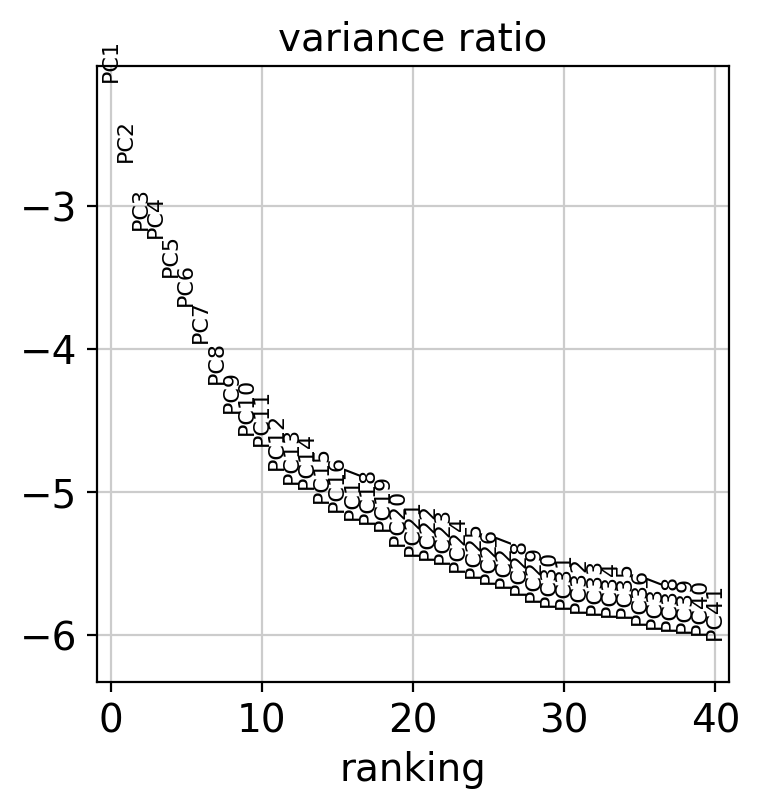

In [32]:
# perform PCA on adata_liver (which contains only HVG (after normalized, log1p) and scaled
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True, random_state=7)

# Elbow plot
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=40, show=True)

# compute neighbourhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=15,
    knn=True,
    method="umap",
    metric="euclidean",
    random_state=7,
)

# compute UMAP embedding
sc.tl.umap(adata, min_dist=0.3, n_components=2, random_state=7)

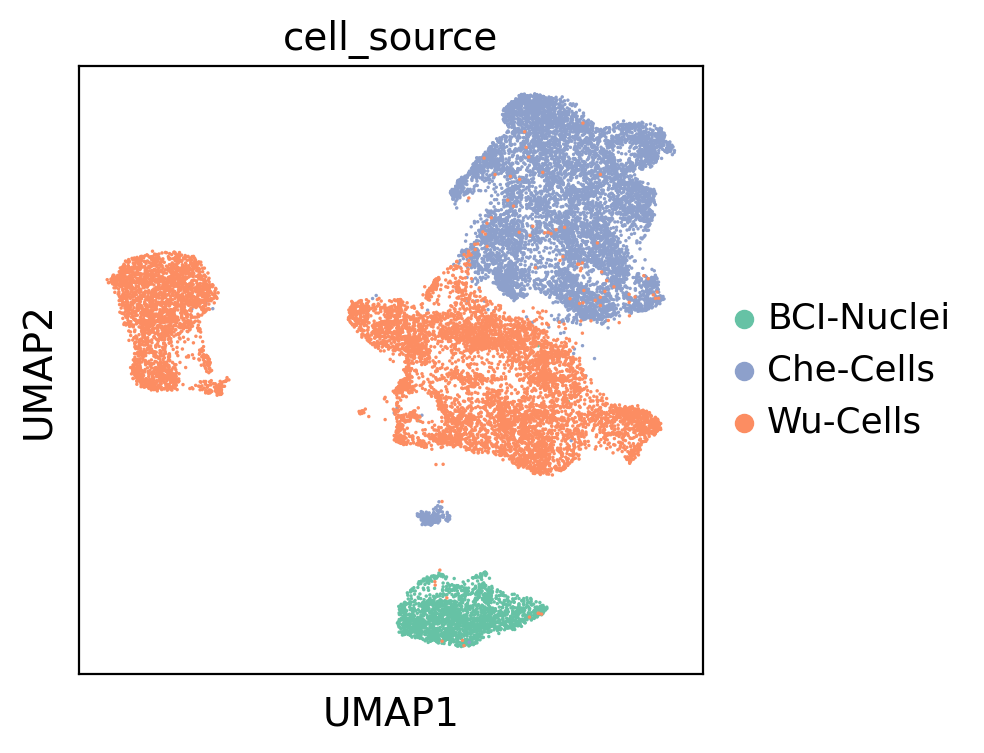

In [33]:
sc.pl.umap(adata, color="cell_source", save="before_integration_scvi.pdf", show=True)

### With batch correction - scVI

In [34]:
print("Number of PCs:", latent.shape[1])
# use scVI latent space for UMAP generation
# set nb pcs to latent representation shape of scvi
# compute neighbourhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=latent.shape[1],
    knn=True,
    method="umap",
    metric="euclidean",
    use_rep="X_scVI",
    random_state=7,
)

# compute UMAP embedding
sc.tl.umap(adata, min_dist=0.3, n_components=2, random_state=7)

Number of PCs: 20


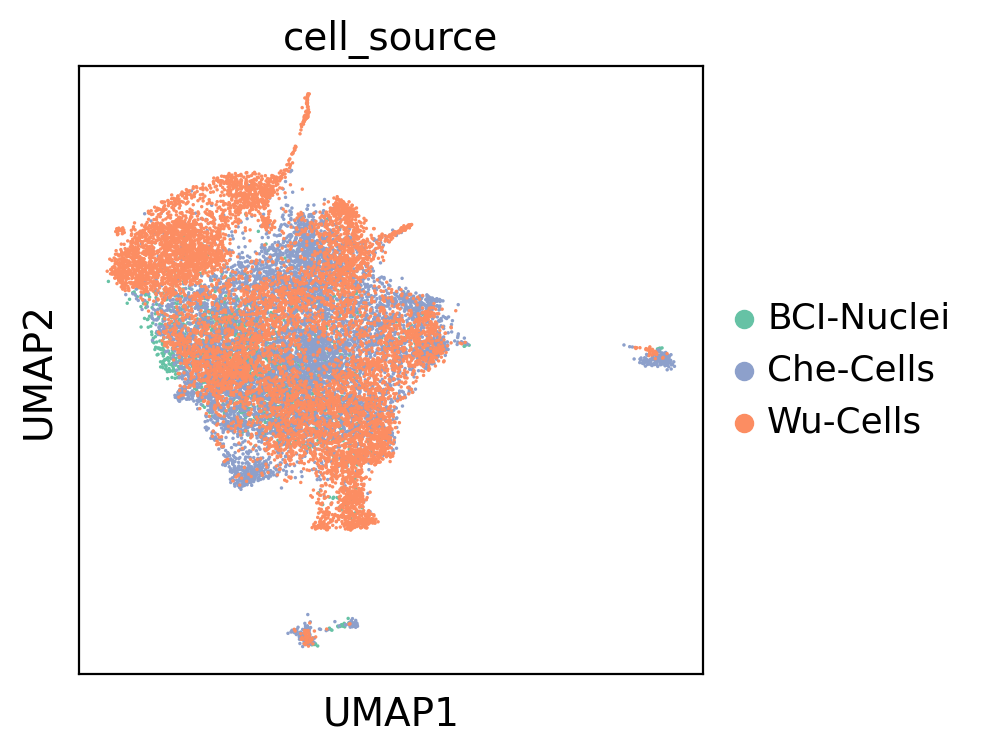

In [35]:
sc.pl.umap(adata, color="cell_source", save="after_integration_scvi.pdf", show=True)

In [40]:
# save to file
adata.write(
    DIR2SAVE.joinpath("Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Myeloid.h5ad")
)

In [41]:
adata.obs.Cell_type.value_counts()

Myeloid        16078
NEU             2848
pDC              204
cDC1/migDC       171
T/NK/ILC          65
B                 12
Stromal            5
CD4                4
CD8                3
T-NK-ILC           3
Endothelial        2
Plasma             2
Mast               1
Name: Cell_type, dtype: int64